# Amazon Dataset 2018 with a uniform distribution of rating scores

The purpose of this notebook is to provide an exploratory analysis of the constructed dataset and ensure that it conforms to specifications. In particular, we want to make sure that we have (1) a `train` dataset with 800 reviews per category and no `Neutral` reviews, (2) a `valid` and `test` datasets having 200 reviews per category each. We also want an average of 10-15 reviews per product in each dataset as well as a uniform distribution of rating scores.

## Description of data

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014. For the task of text summarization, we will only use product reviews data. This dataset contains informations related to each reviews within the following 12 columns:
* **dataset**: dataset type (train/valid/test)
* **category**: product category, e.g. "Gift Cards"
* **prod_id**: ID of the product, e.g. 0000013714
* **review**: text of the review
* **rating**: rating of the product
* **polarity**: sentiment of the review based on the rating score (neutral, positive, or negative)
* **review_len**: number of words contained in the review text
* **review_id**: unique number assigned to each review within each product

## Summary

* Our datasets have a total of 29 product categories. On average, each category has 203 reviews and each product has an average of 13 reviews (8 to 15 reviews). 
* We have a uniform distribution of rating scores within each product. 
* In term of sentiment, we adopt the method used in the [Yelp](https://proceedings.neurips.cc/paper/2015/file/250cf8b51c773f3f8dc8b4be867a9a02-Paper.pdf) and [IMDb](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) datasets and map the scores 1-2 to `Negative`, 4-5 to `Positive`, and 3 to `Neutral`. In order to avoid some biased in the data--as some 3-stars reviews could easily be mistaken--we only consider `Positive` and `Negative` reviews in our training dataset.
* The distribution of sentiment is also uniform for each product as correlated to the rating scores.
* In our datasets, all reviews have a length of 8 to 200 words/tokens

All of this conforms to the specifications established for this dataset and the task of neutral text summarization.

### Text Preprocessing Steps

The review text in our dataset needed to be cleaned. Some of the preprocessing steps are as follow:
1. **Remove markup tags:** this step consists of using BeautifulSoup to remove any HTML/XML-like tags from the review text
2. **Lowercase**: next, we set all text to lowercase for consistency.
3. **Remove URLs**: we remove all strings matching a URL, email address, and phone numbers.
4. **Remove emojis**: it is very common for users to include emojis in their reviews to better express their sentiment. We remove every occurrence of an emiji in the text.
5. **Normalize punctuations:** we reduce the excessif use of punctuation symbols. e.g. we turn `It worked!!!!!!!!` to `It worked!`.
6. **Normalize whitespaces:** we remove excessif whitespaces and turn all of them to a regular space. i.e., we replace `\n`, `\t`, `\r`, etc. to a space.
7. **Expand contractions:** this process consists of converting some contracted words such as `can't` to their full form `cannot`. This helps to normalize certains works. In order to accomplish this, we use a dictionary mapping the contracted word to its full form. 
8. **Expand abbreviations:** similar to the previous step, we convert abbreviated words/expressions like `y/o` and `asap` to their full form `years old` and `as soon as possible`. In order to accomplish that, we use a dictionary mapping the abbreviation to its full form.
9. **Replace type**: about 31% of all reviews contain at least of word/token having a numeric value. In order to deal with numeric values, we use SpaCy's NER detection method and replace each numeric token by its NER tag. e.g. `I paid 500 dollars` becomes `I paid [MONEY]`.
10. **Remove special characters:** at this stage, we remove all special characters except for punctuations and `/` as the forward slash could be used as delimiter, to express metrics, and more.

Some optional steps include correcting spelling of words (very time consumming), removing stopwords, and removing punctuations. As we are dealing with a text summarization task, we want our sentences to as complete and coherent as possible. Therefore, stopwords and punctuations are needed.

## Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime

import re
import json
import string

from bs4 import BeautifulSoup

import unicodedata

import nltk
from nltk.corpus import stopwords

import spacy
from spacy.lang.en import English

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

In [3]:
import time

Do not split tokens by "-". Consider composed words like "like-minded" as one token

In [4]:
# Credit: https://stackoverflow.com/questions/58105967/spacy-tokenization-of-hyphenated-words
custom_infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)

custom_infix_re = compile_infix_regex(custom_infixes)

nlp = English()

nlp.tokenizer.infix_finditer = custom_infix_re.finditer

In [5]:
sns.set()
%matplotlib inline

## Load data

In [6]:
train_path = "../data/raw/20220420_amazon_reviews_train.csv"
valid_path = "../data/raw/20220420_amazon_reviews_valid.csv"
test_path = "../data/raw/20220420_amazon_reviews_test.csv"

In [7]:
train_df = pd.read_csv(train_path)
train_df.shape

(10595, 7)

In [8]:
train_df.head()

,category,prod_id,rating,polarity,review,review_len,review_id
0,AMAZON_FASHION,B001LFP0EO,2.0,negative,The bandit wouldn't stay put...at all. How co...,88,0
1,AMAZON_FASHION,B001LFP0EO,5.0,positive,I am wearing my Bandit now. It made my belly g...,39,1
2,AMAZON_FASHION,B001LFP0EO,1.0,negative,i was so excited to get to order this while i ...,189,2
3,AMAZON_FASHION,B001LFP0EO,5.0,positive,I was very skeptical about purchasing this but...,144,3
4,AMAZON_FASHION,B001LFP0EO,1.0,negative,I ordered the XL in the Belly Bandit because t...,112,4


In [9]:
valid_df = pd.read_csv(valid_path)
valid_df.shape

(4525, 7)

In [10]:
test_df = pd.read_csv(test_path)
test_df.shape

(3105, 7)

In [11]:
df = pd.concat([train_df, valid_df])
df.shape

(15120, 7)

## Exploratory Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 4524
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   category    15120 non-null  object 
 1   prod_id     15120 non-null  object 
 2   rating      15120 non-null  float64
 3   polarity    15120 non-null  object 
 4   review      15120 non-null  object 
 5   review_len  15120 non-null  int64  
 6   review_id   15120 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 945.0+ KB


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10595 entries, 0 to 10594
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   category    10595 non-null  object 
 1   prod_id     10595 non-null  object 
 2   rating      10595 non-null  float64
 3   polarity    10595 non-null  object 
 4   review      10595 non-null  object 
 5   review_len  10595 non-null  int64  
 6   review_id   10595 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 579.5+ KB


### category

In [15]:
df["category"].value_counts().describe()

count     24.000000
mean     630.000000
std      280.881532
min      173.000000
25%      305.250000
50%      801.500000
75%      855.500000
max      962.000000
Name: category, dtype: float64

In [72]:
train_df["category"].unique().shape

(24,)

In [16]:
train_df["category"].value_counts().describe()

count     24.000000
mean     441.458333
std      236.419667
min       73.000000
25%      256.750000
50%      447.500000
75%      591.000000
max      818.000000
Name: category, dtype: float64

In [73]:
valid_df["category"].unique().shape

(23,)

In [17]:
valid_df["category"].value_counts().describe()

count     23.000000
mean     196.739130
std      127.884969
min       37.000000
25%       82.000000
50%      156.000000
75%      298.000000
max      399.000000
Name: category, dtype: float64

In [74]:
test_df["category"].unique().shape

(3,)

In [18]:
test_df["category"].value_counts().describe()

count       3.000000
mean     1035.000000
std       882.708899
min        45.000000
25%       682.500000
50%      1320.000000
75%      1530.000000
max      1740.000000
Name: category, dtype: float64

On average per category, we have 203 reviews in the `train` dataset, 199.83 reviews in the `valid` dataset, and 203.79 reviews in the `test` dataset.

### prod_id

In [24]:
df["prod_id"].value_counts().value_counts()

15     31
14     29
16     21
13     20
20     18
       ..
112     1
113     1
117     1
120     1
5       1
Name: prod_id, Length: 97, dtype: int64

In [20]:
df["prod_id"].value_counts().describe()

count    382.000000
mean      39.581152
std       44.111080
min        5.000000
25%       15.250000
50%       21.000000
75%       44.000000
max      276.000000
Name: prod_id, dtype: float64

In [69]:
train_df["prod_id"].unique().shape

(267,)

<AxesSubplot:>

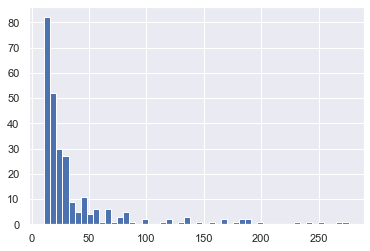

In [25]:
train_df["prod_id"].value_counts().hist(bins=50)

In [70]:
valid_df["prod_id"].unique().shape

(115,)

<AxesSubplot:>

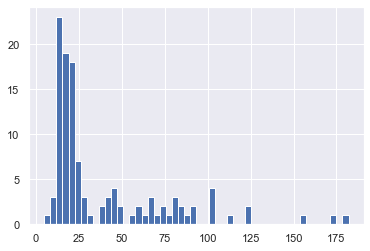

In [26]:
valid_df["prod_id"].value_counts().hist(bins=50)

In [71]:
test_df["prod_id"].unique().shape

(207,)

<AxesSubplot:>

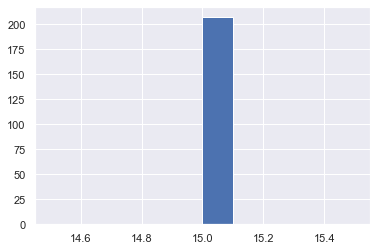

In [27]:
test_df["prod_id"].value_counts().hist()

On average each product has a total of about 13 reviews (8 to 15)

### rating

<AxesSubplot:>

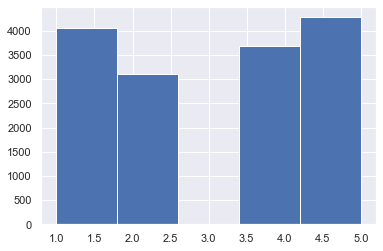

In [28]:
df["rating"].hist(bins=5)

<AxesSubplot:>

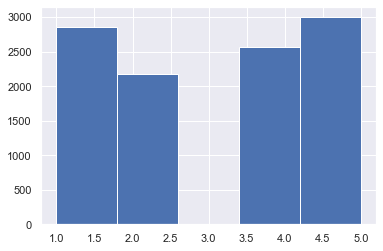

In [29]:
train_df["rating"].hist(bins=5)

<AxesSubplot:>

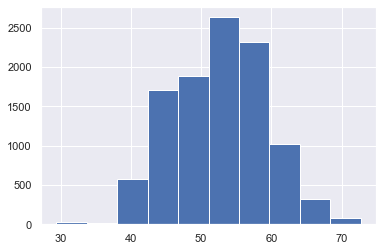

In [32]:
train_pol = train_df["prod_id"].apply(lambda x: 100 * train_df.loc[(train_df["prod_id"] == str(x)) & (train_df["rating"] >= 3.5)].shape[0] / train_df.loc[train_df["prod_id"] == str(x)].shape[0])
train_pol.hist()

<AxesSubplot:>

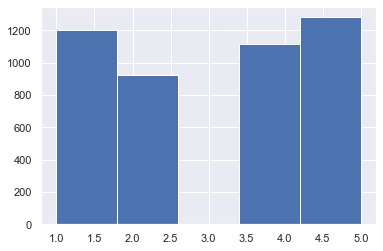

In [33]:
valid_df["rating"].hist(bins=5)

<AxesSubplot:>

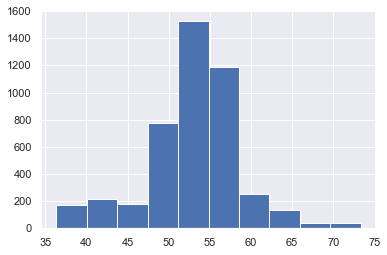

In [34]:
valid_pol = valid_df["prod_id"].apply(lambda x: 100 * valid_df.loc[(valid_df["prod_id"] == str(x)) & (valid_df["rating"] >= 3.5)].shape[0] / valid_df.loc[valid_df["prod_id"] == str(x)].shape[0])
valid_pol.hist()

<AxesSubplot:>

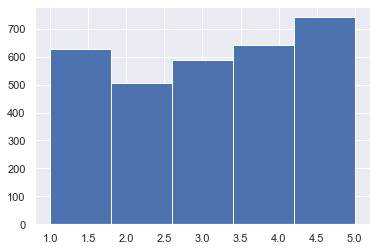

In [35]:
test_df["rating"].hist(bins=5)

<AxesSubplot:>

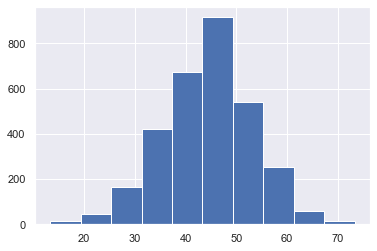

In [36]:
test_pol = test_df["prod_id"].apply(lambda x: 100 * test_df.loc[(test_df["prod_id"] == str(x)) & (test_df["rating"] >= 3.5)].shape[0] / test_df.loc[test_df["prod_id"] == str(x)].shape[0])
test_pol.hist()

Overall, we have a uniform distribution of ratings for each product.

### polarity

<AxesSubplot:>

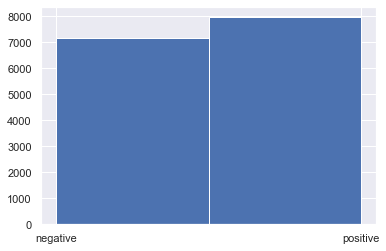

In [37]:
df["polarity"].hist(bins=2)

<AxesSubplot:>

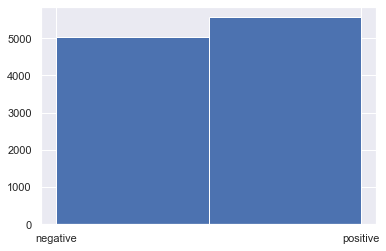

In [38]:
train_df["polarity"].hist(bins=2)

<AxesSubplot:>

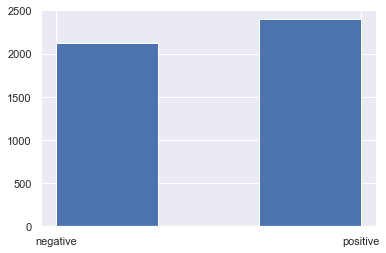

In [39]:
valid_df["polarity"].hist(bins=3)

<AxesSubplot:>

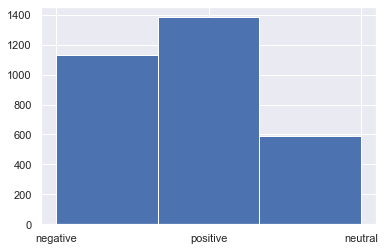

In [40]:
test_df["polarity"].hist(bins=3)

Overall, we have an equal number of postive and negative reviews. The number of neutral reviews is about half of that of the psoitive and negative reviews. This is because, negative reviews include 1 and 2-stars while neutral reviews only include 3-stars. Moreover, we have a uniform distribution of review scores for each product.

### review_len

In [41]:
df["review_len"].describe()

count    15120.000000
mean        52.531481
std         43.273302
min          8.000000
25%         21.000000
50%         37.000000
75%         71.000000
max        205.000000
Name: review_len, dtype: float64

<AxesSubplot:>

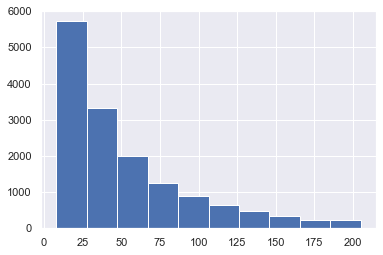

In [48]:
df["review_len"].hist()

In [42]:
train_df["review_len"].describe()

count    10595.000000
mean        52.665125
std         42.813031
min          8.000000
25%         21.000000
50%         38.000000
75%         72.000000
max        205.000000
Name: review_len, dtype: float64

<AxesSubplot:>

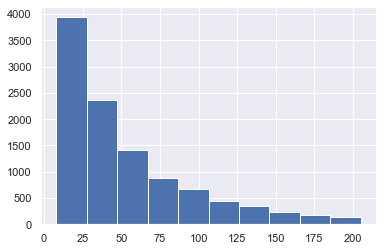

In [43]:
train_df["review_len"].hist()

In [44]:
valid_df["review_len"].describe()

count    4525.000000
mean       52.218564
std        44.335533
min         8.000000
25%        20.000000
50%        36.000000
75%        71.000000
max       205.000000
Name: review_len, dtype: float64

<AxesSubplot:>

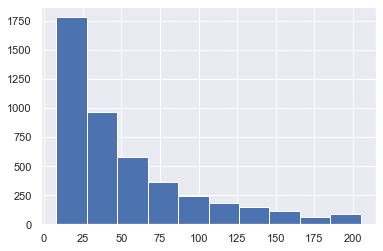

In [49]:
valid_df["review_len"].hist()

In [50]:
test_df["review_len"].describe()

count    3105.000000
mean       50.899839
std        39.649478
min         8.000000
25%        23.000000
50%        35.000000
75%        65.000000
max       205.000000
Name: review_len, dtype: float64

<AxesSubplot:>

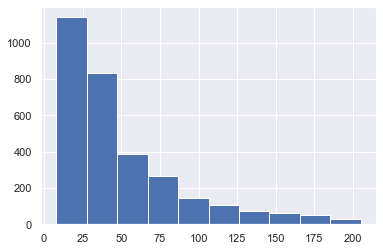

In [51]:
test_df["review_len"].hist()

All review texts are between 8 and 200 words long.

### review

In [52]:
all_df = pd.concat([train_df, valid_df, test_df])
all_df.shape

(18225, 7)

In [53]:
all_df["review"].head(10)

0    The bandit wouldn't stay put...at all.  How co...
1    I am wearing my Bandit now. It made my belly g...
2    i was so excited to get to order this while i ...
3    I was very skeptical about purchasing this but...
4    I ordered the XL in the Belly Bandit because t...
5    I bought 2 bandits, one small & one xs, I worn...
6    I bought it for my sister and she loves it... ...
7    I bought this bandit in the hopes that I could...
8    I want to love this product as I had such high...
9    Waste of money. Im hourglass shape trying to g...
Name: review, dtype: object

### Text cleaning functions

#### Lowercase

In [54]:
def to_lowercase(text):
    return text.lower()

#### Remove URLs and Email

In [55]:
def remove_urls(text):
    text = str(text)
    url_re = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+' +\
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]' +\
        r'\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}' +\
        r'|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    email_re = r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
    phone_re = r"^[\+]?[(]?[0-9]{3}[)]?[-\s\.]?[0-9]{3}[-\s\.]?[0-9]{4,6}$"
    
    text = re.sub(url_re, " ", text)
    text = re.sub(email_re, " ", text)
    text = re.sub(phone_re, " ", text)
    
    return text

#### Remove markups tags (HTML, XML, etc.)

In [56]:
def remove_markup_tags(text):
    new_text = BeautifulSoup(text, 'html.parser').get_text()
    return new_text

#### Remove emojis

In [57]:
def remove_emojis(text):
    # Remove exagerated parenthesis
    text = re.sub(r"([\(\)])\1+", "\1", text)
    
    # Remove emoticons and emojis
    emoticon_re = r"\:\-?\)|\:\-?\(|\;\-?\)|\:\-?\>|\:\-?p|\:\-?\/|\:\-?\\|\:\-?1|\:\-?d|\%\*\}|\:\-?\*|\'\:\-?\)" +\
                  r"|\:\-\/|\:p|\:\/|\:o" +\
                  r"|\:\-?o|\:\'\-?\(|\:\-?\{\)|\:\-?\)\>|\%\-?\)|\&\:\-?\\|\(\:\-?\)|o\:\-?\)|\>\:\-?\>|8\=x|\(p\-?\||\:\-?\[|\<\:\+d"
    emojis_re = u"(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])"
    text = re.sub(emojis_re, " ", text)
    text = re.sub(emojis_re, " ", text)
    return text

#### Normalize punctuations

In [58]:
def normalize_punctuations(text):
    text = str(text)
    text = re.sub(r'([\!\?,;\:])\1+', r'\1', text)
    text = re.sub(r'\.{2,}', r'...', text)
    text = re.sub(r'\.{3}( )+', r'. ', text)
    text = re.sub(r'\.{3}', ', ', text)
    return text

#### Normalize whitespaces

In [59]:
def normalize_whitespaces(text):
    text = str(text)
    text = re.sub(r"//t", r"\t", text)
    text = re.sub(r"( )+", r" ", text)
    text = re.sub(r"(\n)+", r" ", text)
    text = re.sub(r"(\r)+", r" ", text)
    text = re.sub(r"(\t)+", r" ", text)
    return text.strip(" ")

#### Expand contractions

In [60]:
def __expand_word_form(text, map_):
    pattern = re.compile(r'(^|\W+)({})(\W+|$)'.format('|'.join(map_.keys())), flags=re.IGNORECASE|re.DOTALL)
    def get_match(contraction):
        reg = r'({})'.format('|'.join([re.escape(k) for k in map_.keys()]))
        match = contraction.group(2)
        #match = re.search(reg, match, flags=re.IGNORECASE|re.DOTALL)
        #match = match.group(0)
        first_char = match[0]
        expanded = map_.get(match) if map_.get(match) else map_.get(match.lower())
        expanded = expanded  #first_char + expanded[1:]
        if expanded is None:
            return expanded
        return contraction.group(1) + expanded + contraction.group(3) 
    new_text = pattern.sub(get_match, text)
    new_text = re.sub("'", "", new_text)
    return new_text

In [61]:
with open(f"../data/english_contractions.json", "r") as fd:
    CONTRACTION_MAP = json.loads(fd.read())

In [62]:
def expand_contractions(text):
    text = str(text)
    return __expand_word_form(text, map_=CONTRACTION_MAP)

#### Expand abbreviations

In [63]:
with open(f"../data/eng_abbrv.json", "r") as fd:
    ABBRV_MAP = json.loads(fd.read())

In [64]:
def expand_abbreviations(text):
    text = str(text)
    return __expand_word_form(text, map_=ABBRV_MAP)

Preprocess data

In [65]:
def preprocess(text):
    text = to_lowercase(text)
    text = remove_urls(text)
    text = remove_markup_tags(text)
    text = remove_emojis(text)
    text = normalize_punctuations(text)
    text = normalize_whitespaces(text)
    text = expand_contractions(text)
    text = expand_abbreviations(text)
    return text

We apply the preprocessing steps

In [66]:
processed_df = all_df.copy()
processed_df.shape

(18225, 7)

In [51]:
st = time.perf_counter()
processed_df["review"] = df["review"].apply(preprocess)
print(f"Completed after {(time.perf_counter()-st):.2f} seconds.")

Completed after 29.98 seconds.


In [52]:
processed_df["review"].head(10)

0    i smoke 100s and these are not made for them. ...
1    this brand has been around a long time and you...
2    this was a gift and the party was very happy w...
3    very pleased with this cigarette case. I have ...
4              not good for me i thought it was 100 pk
5         it is ok, it does not close if you have 100s
6    wonderfuli have purchased several of these. th...
7    this case does not even fit a regular pack of ...
8    we tried these shirts in the pinpoint fabric, ...
9    i was looking at the previous review and i thi...
Name: review, dtype: object

#### Dealing with numeric values

In [53]:
numeric_re = r"(^| +|\s+)([0-9]+(\,|\.|\-+|_+|[a-zA-Z]+|\/+|\\|\:| +|\s+)?)"

In [54]:
prc = round(100 * processed_df["review"].apply(lambda x: re.search(numeric_re, str(x)) is not None).sum() / processed_df.shape[0], 2)
print(f"{prc}% of reviews contain a token starting with a number")

prc = round(100 * processed_df["review"].apply(lambda x: re.search("\d", str(x)) is not None).sum() / processed_df.shape[0], 2)
print(f"{prc}% of reviews contain a token containing a number")

27.54% of reviews contain a token starting with a number
31.13% of reviews contain a token containing a number


In [55]:
def count_numeric_tokens(corpus):
    counter = dict()
    doc_counter = np.zeros((corpus.shape[0], 2))
    
    for i,doc in enumerate(corpus):
        tokens = doc.strip().split()
        count = 0
        n_tokens = 0
        for token in tokens:
            if token is None or re.search("^[\.,\?\!\@\#\^\&\:;\'\>\<]+$", token):
                continue
                
            n_tokens += 1
            
            if not re.search(numeric_re, token):
                continue
            
            count += 1
            
            if counter.get(token) is None:
                counter[token] = 1
            else:
                counter[token] += 1
                
        doc_counter[i][0] = count
        doc_counter[i][1] = n_tokens
    
    total = doc_counter.sum(0)
    prc = doc_counter[:, 0] / doc_counter[:, 1]
                
    print(f"{(100 * (total[0]/total[1])):.2f}% ({total[0]}/{total[1]}) of all tokens are numerical.")
    print(f"On average, {(100 * prc.mean(0)):.2f}% of tokens in a document are numerical. min: {(100 * prc.min()):.2f}%, max: {(100 * prc.max()):.2f}%")
    print(f"{(100 * prc[prc > 0.05].shape[0] / prc.shape[0]):.2f}% of documents are composed of more than 5% numeric tokens")
    
    return counter

In [56]:
counter = count_numeric_tokens(corpus=processed_df["review"].values)
numeric_tokens = pd.DataFrame.from_dict(counter, orient="index", columns=["count"])
numeric_tokens = numeric_tokens.sort_values(by=["count"], ascending=True)

0.95% (17949.0/1890663.0) of all tokens are numerical.
On average, 0.89% of tokens in a document are numerical. min: 0.00%, max: 33.33%
4.44% of documents are composed of more than 5% numeric tokens


In [57]:
numeric_tokens.index[:150].values

array(['1-4?', '243', '1000%.', '18-24', '12-', '12-hour.', '65-90',
       '1-20th.', '98623', '3yrs', '23,', '263!', '63lbss', '3-burner',
       '6yrs', '60lbs', '2.0.', '26-26.5', '27-28', '21st,', '10~15',
       '3lbs,', '80db.', '1you', '270', '4-8', '22yr.', '6+.', '24hrs',
       '8".', '2016-', '99+', '500+', '34c', '61)', '55cm', '80%.',
       '45cm', '6/11/17.', '4hr', '166', '1505', '80#', '0.7', '65cm',
       '140lbs', '3,4,', '20w', '7518s.', '7ea.', '690s', '2400',
       '15amps', '120v', '42690guide', '10/24', '6912', '895pk', '310p',
       '0.3amp', '500$', '788', '40-694', '788.', '61").', '2x12s', '6/4',
       '3ea.', '5+.', '7529k,', '6394-21', '5w', '35w.', '10count.',
       '3000k', '2700k', '3000k.', '38.25', '16s', '6000k', '6mar2015:',
       '140w', '255', '1.8"', '40it', '16t', '24t', '5007nk', '6390-21',
       '4x4s', '7-1/4', '12.6w', '708', '52"!)', '9!', '750,000',
       '600,000,', '8.01', '8.01.', '1898,', '1919', '1888.', '1996,',
       '38)'

We can use SpaCy NER tags to replace certain numeric tokens by their type

In [58]:
NER = spacy.load("en_core_web_sm")

In [59]:
NUMERIC_TOKENS = ["DATE", "TIME", "MONEY", "QUANTITY"]

In [60]:
samples = [
    "American planning for a post-war occupation of Japan began as early as February 1942.",
    "I ran 2 miles at 6am and won a $500 prize.",
    "For 36 minutes the disk spin at 3500-rpm.",
    "You have a 48-hours time window to lift 150lbs as a 35 years old man and 6 feet tall.",
    "I am 6 years old",
    "Today is 03/14/2022. Yesterday was March 13th 2022. The day before that was 12th of Mar 2022."
]

DATE_RE = r"(^(19|20)\d\d[- /.](0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])$)" +\
          r"|(^(0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$)" +\
          r"|(^(0[1-9]|[12][0-9]|3[01])[- /.](0[1-9]|1[012])[- /.](19|20)\d\d$)"

RELATIVE_DATE_RE = r"today|yesterday|tomorrow|now"

for s in samples:
    s = preprocess(s)
    print(f"BEFORE:: {s}")
    doc = NER(s)
    for tok in doc.ents:
        #print(tok.text, tok.label_)
        tag = str(tok.label_)
        if re.search(DATE_RE, tok.text):
            tag = "DATE"
        #if re.search(RELATIVE_DATE_RE, tok.text):
        #    continue
        
        if tag in NUMERIC_TOKENS:
            if tag == "DATE" and re.search(r"years?( |\s|-)+old|y/o|yrs?( |\s|-)+old", tok.text):
                tag = "AGE"
            s = re.sub(re.escape(tok.text), f"[{tag}]", s)
    print(f" AFTER:: {s}\n")

BEFORE:: american planning for a post-war occupation of japan began as early as february 1942.
 AFTER:: american planning for a post-war occupation of japan began [DATE].

BEFORE:: i ran 2 miles at 6am and won a $500 prize.
 AFTER:: i ran [QUANTITY] at [TIME] and won a $[MONEY] prize.

BEFORE:: for 36 minutes the disk spin at 3500-rpm.
 AFTER:: for [TIME] the disk spin at 3500-rpm.

BEFORE:: you have a 48-hours time window to lift 150lbs as a 35 years old man and 6 feet tall.
 AFTER:: you have a [TIME] time window to lift [DATE] as a [AGE] man and [QUANTITY] tall.

BEFORE:: i am 6 years old
 AFTER:: i am [AGE]

BEFORE:: today is 03/14/2022. yesterday was march 13th 2022. the day before that was 12th of mar 2022.
 AFTER:: [DATE] is [DATE]. [DATE] was [DATE]. [DATE] before that was [DATE].



In [61]:
def replace_by_type(text):
    DATE_RE = r"(^(19|20)\d\d[- /.](0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])$)" +\
          r"|(^(0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$)" +\
          r"|(^(0[1-9]|[12][0-9]|3[01])[- /.](0[1-9]|1[012])[- /.](19|20)\d\d$)"
    
    NUMERIC_TOKENS = ["DATE", "TIME", "MONEY", "QUANTITY"]
    
    # First, we remove bracket as they are used for type tokens repalcement
    text = re.sub(r"\[|\]", " ", text)
    
    # We replace certain numeric tokens with their type
    doc = NER(text)
    for tok in doc.ents:
        #print(tok.text, tok.label_)
        tag = str(tok.label_)
        if re.search(DATE_RE, tok.text):
            tag = "DATE"
            
        if tag in NUMERIC_TOKENS:
            if tag == "DATE" and re.search(r"years?( |\s|-)+old|y/o|yrs?( |\s|-)+old", tok.text):
                tag = "AGE"
            text = re.sub(re.escape(tok.text), f" [{tag}] ", text)
    
    return text

In [62]:
st = time.perf_counter()
processed_df["review"] = processed_df["review"].apply(replace_by_type)
print(f"completed after {(time.perf_counter() - st):.2f} seconds")

completed after 395.79 seconds


In [63]:
prc = round(100 * processed_df["review"].apply(lambda x: re.search(numeric_re, str(x)) is not None).sum() / processed_df.shape[0], 2)
print(f"{prc}% of reviews contain a token starting with a number")

prc = round(100 * processed_df["review"].apply(lambda x: re.search("\d", str(x)) is not None).sum() / processed_df.shape[0], 2)
print(f"{prc}% of reviews contain a token containing a number")

18.77% of reviews contain a token starting with a number
21.13% of reviews contain a token containing a number


In [64]:
_ = count_numeric_tokens(corpus=processed_df["review"].values)

0.60% (11196.0/1873989.0) of all tokens are numerical.
On average, 0.56% of tokens in a document are numerical. min: 0.00%, max: 28.57%
2.59% of documents are composed of more than 5% numeric tokens


#### Remove special characters

In [65]:
def remove_special_chars(text):
    text = str(text)
        
    # Replace parenthesis with spaces
    new_text = re.sub(r"\(|\)", r" ", text)
    
    # Normalize dashes
    new_text = re.sub("\–", "-", new_text)
    
    # Normalise '
    new_text = re.sub("\`", "'", new_text)
        
    # Turn "--" and underscores (_) to spaces
    new_text = re.sub(r"(\-|\–){2,}|_+", r" ", new_text)
        
    # handle forward slash
    #slash_pattern = re.compile(r"([a-zA-Z\'])(\/)([a-zA-Z\'])", flags=re.IGNORECASE|re.DOTALL)
    #new_text = slash_pattern.sub(
    #    lambda contraction: contraction.group(1).strip() + " or " +  contraction.group(3).strip(), new_text)
        
    # define the pattern to keep
    exclude_re = r'[^a-zA-Z0-9\.,!\?\/:;\'\-\–\[\] ]+'
    new_text = re.sub(exclude_re, ' ', new_text)
        
    # remove hanging dash
    new_text = re.sub(r"( )+\-( )+", " ", new_text)
    new_text = re.sub(r"( |\s)+[\/\-\–\\]+|[\/\-\–\\]+( |\s)+", " ", new_text)
        
    return new_text

In [66]:
st = time.perf_counter()
processed_df["review"] = processed_df["review"].apply(remove_special_chars)
print(f"completed after {(time.perf_counter() - st):.2f} seconds")

completed after 2.46 seconds


#### Correct spelling

In [67]:
with open(f"../data/eng_misspelled_dict.json", "r") as fd:
    MISSPELLED_MAP = json.loads(fd.read())

In [68]:
def __reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> woords
        yaaaaaaaaaaaaaaay -> yaay
    """
    correction = str(text)
    return re.sub(r'([\w])\1{3,}', r'\1', correction)

def is_numeric(text):
    if not re.search("[0-9,\%\.\$]", text):
        return False
    return True

def spelling_correction(text):
    text = str(text)
    if len(text) < 1:
        return ""
        
    token_list = [str(tok) for tok in nlp.tokenizer(text)]
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if word not in string.punctuation and not is_numeric(word):
            replacement = __reduce_exaggerations(word)
            replacement = __expand_word_form(text, map_=MISSPELLED_MAP)
            word = replacement
            token_list[word_pos] = word
        
    return " ".join(token_list).strip()

In [69]:
#st = time.perf_counter()
#processed_df["review"] = processed_df["review"].apply(spelling_correction)
#print(f"completed after {(time.perf_counter() - st):.2f} seconds")

#### Add spaces around punctuations

This helps with the processing and do not have much of an impact on data quality as the text will still be tokenized

In [70]:
def sep_punctuations(text):
    text = " ".join([str(w) for w in nlp.tokenizer(text)])
    return text

In [71]:
#st = time.perf_counter()
#processed_df["review"] = processed_df["review"].apply(sep_punctuations)
#print(f"completed after {(time.perf_counter() - st):.2f} seconds")

In [72]:
processed_df["review"].head()

0    i smoke 100s and these are not made for them. ...
1    this brand has been around a long time and you...
2    this was a gift and the party was very happy w...
3    very pleased with this cigarette case. I have ...
4              not good for me i thought it was 100 pk
Name: review, dtype: object

#### Remove punctuations (optional)

In [73]:
def remove_punctuations(text):
    PUNCTUATIONS = r"^[\.;,\:\?\!\^\(\)]$"
    text = ''.join([c for c in text if not re.search(PUNCTUATIONS, c)])
    return text

In [74]:
#processed_df["review"] = processed_df["review"].apply(remove_punctuations)

#### Remove stopwords (optional)

In [75]:
def remove_stopwords(text):
    text = [str(w) for w in nlp.tokenizer(text) if str(w) not in stopwords.words('english')]
    text = " ".join(text)
    text = re.sub("\[ +", " [", text)
    text = re.sub(" +\]", "] ", text)
    return text

In [76]:
st = time.perf_counter()
processed_df["review"] = processed_df["review"].apply(remove_stopwords)
print(f"completed after {(time.perf_counter() - st):.2f} seconds")

completed after 206.12 seconds


#### One last cleaning step for good mesure

In [77]:
def clean_whitespaces(text):
    text = re.sub(r'\s+|( )+', ' ', text.strip()).strip()
    return text

In [78]:
st = time.perf_counter()
processed_df["review"] = processed_df["review"].apply(clean_whitespaces)
print(f"completed after {(time.perf_counter() - st):.2f} seconds")

completed after 0.66 seconds


In [79]:
processed_df["review"].head(15)

0     smoke 100s made . get cigarettes close . disap...
1     brand around long time count good quality merc...
2     gift party happy could little larger larger pa...
3     pleased cigarette case . I exact one lost . ho...
4                                   good thought 100 pk
5                                       ok , close 100s
6     wonderfuli purchased several . last forever un...
7     case even fit regular pack cigarettes . really...
8     tried shirts pinpoint fabric , washing worst w...
9     looking previous review think missed boat one ...
10    made china . priced . mine eagle . suggest any...
11    gorgeous shirt , fits expected looks sharp per...
12                     shirt ok ok neck sleeve body big
13    great fit , great deal . classic shirt ! paul ...
14    reviewers said , shirt fit fine package , one ...
Name: review, dtype: object

#### Find least common words

In [80]:
def count_occurrences(corpus):
    counter = dict()
    for i,doc in enumerate(corpus):
        if re.search("\[MONEY\][a-z]+", doc):
            print(doc)
            break
        tokens = re.split(r"[\.,\!\?; ]+|\s+", doc.strip())
        for token in tokens:
            if token == "":
                continue
            if counter.get(token) is None:
                counter[token] = 1
            else:
                counter[token] += 1
    
    return counter

In [81]:
counter = count_occurrences(corpus=processed_df["review"].values)
counter_df = pd.DataFrame.from_dict(counter, orient="index", columns=["count"])
counter_df = counter_df.sort_values(by=["count"], ascending=True)

In [82]:
print(f"{counter_df.shape[0]} unique tokens")

46022 unique tokens


Tokens starting with a number

In [83]:
counter_df[[True if re.search(numeric_re, str(idx)) else False for idx in counter_df.index.values]].index.values[:150]

array(['50h', '505and', '3ccd', '3-piece', '12x17', '10x14', '5hz-32khz',
       '440ml', '20hz-20khz', '25yr', '447s', '222', '314', '1/31/12',
       '52x24x52', '880', '440', '6170', '2005and', '5yrs', '8yrs', '5d',
       '60d', '700dj', '1xx', '48x70', '1463', '336', '9/13', '532',
       '75x21', '303', '151', '5x5', '4-d', '210gph', '325', '02720',
       '70602', '20gal', '25feet', '486', '3500', '1short', '528', '425',
       '720343425000', '6-ply', '2nd/3rd', '1000mk3', '170', '204', '251',
       '2i2', '75db', '11/14', '11it', '1:100', '4x5', '3inch', '007s',
       '6:22', '11/30/09', '108', '152', '110lbs', '2yrs', '70s',
       '2/14/16', '75:1', '4th-5th', '1:33:1', '1:77:1', '587', '451',
       '1:85:1', '76cs', '1800s', '1096', '48x24x48', '80s/90s',
       '5-start', '12/10/32', '48x16x48', '24/10/40a', '600x', '2000pro',
       '2kpro', '2800', '3yr-old', '400mhz', '300mhz', '7200rpm',
       '350mhz', '6yrs', '3-burner', '63lbss', '263', '690s', '2400',
       '1

Tokens containing a number but not starting with a number

In [84]:
counter_df[[True if re.search(f"\d|(?:({numeric_re}))", str(idx)) else False for idx in counter_df.index.values]].index.values[:150]

array(['ss35c', 'sc35c', 'm97xe', 'atp95e', '50h', 'm6', '505and',
       'epx76', 'pl-570', 'dvx-100b', '3ccd', 'pvgs-120', 'vx2100',
       'ntg2', 'trv-320', '3-piece', 'rp-1', 'at-lp120-usb', 'at822',
       'sl-qd33', 'ufo202', 'sl-dd33', 'at95e', 'pj260v', 'qd-33',
       'sm-58s', 'q4s', 'cn5625al', 'hf100', 'cs6', 'icd-ax412', 'zi8',
       'me-51s', 'ecm-ds70p', 'a1u', 'hero2', 'vn-4100pc', 'h2/4',
       'atr97', 'ecm-f01', '12x17', '10x14', '5hz-32khz', '440ml',
       'at33ev', '20hz-20khz', '25yr', 'jr1', '447s', 'm44', 'gm-2',
       'cv320', '222', 'gq756', 's31', 'sm-58', '314', 'mdr-828ls',
       'sp-4c', 'srm1801', 'srm450v2', '1/31/12', 'zlx-p12', 'ubb1002',
       'cl-ext-ps2', 'pro88w-r35', 'nanokontrol2', '52x24x52', 'dvr-105',
       '880', '440', 'x-15s', '6170', '2005and', 'mid-310', 'mpa-46',
       '5yrs', '8yrs', 'psr-175', 'sm48', 'iphone5', 'sgm-2x', '5d',
       't2i', 'h4', '60d', 'g20', 'd800', 'sr-80s', '700dj', 'v700',
       'mdr-v700', 'rp-dh1200',

Tokens containing a special character except for a dash "-"

In [85]:
counter_df[[True if not re.search("\d", str(idx)) and re.search("[^a-zA-Z0-9\-]+", str(idx)) else False for idx in counter_df.index.values]].index.values[:150]

array(['hips/', 'stock/', 'com/redeemgift', '/about', 'dead://', 'it/',
       '/wolfsblood', "'m", 'o/', "'ll", "up'being", 'less/',
       '/re-ranked', 'warped/', 'com/poets/stevenson/travel', ':-/', ':p',
       ':/', ':o', "n't", "'", "'s", 'and/or', '[AGE]', '[QUANTITY]', '/',
       '[TIME]', ':', '[MONEY]', '[DATE]'], dtype=object)

Tokens containing a dash "-" (composed words)

In [86]:
counter_df[[True if not re.search("\d", str(idx)) and re.search("\-", str(idx)) else False for idx in counter_df.index.values]].index.values[:150]

array(['fisher-price', 're-shoot', 'anti-shock', 'semi-pro',
       'non-condensor', 'hot-shoe', 'off-cam', 'direct-drive',
       'good-quality', 'hi-tension', 'post-editing', 'non-powered',
       'run-down', 'non-directional', 'power-on', 'wm-pros', 'high-mid',
       'jenn-aire', 'push-to-turn', 'high-performance', 'ear-phones',
       'f-v', 'hard-plastic', 'line-in', 'hi-lo', 'mis-wired',
       'de-soldered', 'perfect-straw', 'flex-tip', 'anal-retentive',
       'look-thing', 'sound-thing', 'wlx-pros', 'whisper-level',
       'central-it', 'media-not', 'pre-recorded', 'p-mounts', 'ka-chunk',
       'p-cartridge', 'voice-over', 'horror-type', 'sound-effects',
       'male-dominated', 'mother-daughter', 'albania-of',
       'breadth-taking', 're-learning', 'less-than-better',
       'screwball-comedy', 'drive-ins', 'wankers-i', 'conversion-since',
       'end-of-the-world', 'french-canadian', 'bfi-unlike',
       'companies-bfi', 'public-they', 'school-skipping', 'x-filers',
     

Least common words and typos

In [87]:
counter_df[[True if not re.search("\d", str(idx)) and not re.search("[^a-zA-Z0-9]+", str(idx)) else False for idx in counter_df.index.values]].index.values[:150]

array(['sinple', 'styluses', 'cruised', 'headshel', 'elac', 'miracord',
       'acos', 'anotherwith', 'tt', 'despicably', 'transients',
       'aliveness', 'audiobuddy', 'lotsa', 'vows', 'vtf', 'prosumer',
       'cl', 'dslrs', 'nullified', 'cartratige', 'foota', 'someway',
       'noisily', 'couter', 'indpendent', 'wispers', 'sennheizer', 'atr',
       'consumeri', 'harmonics', 'deviated', 'gram', 'counterweight',
       'interchangability', 'guesswork', 'premieres', 'denoiser', 'ats',
       'visualdude', 'improv', 'soundhole', 'placements', 'contends',
       'thisdrags', 'atk', 'audiotechnica', 'produt', 'nomally',
       'recommnend', 'thisearned', 'acamcorder', 'conferences', 'gli',
       'oursingers', 'rejection', 'samson', 'miking', 'swich',
       'styrifoam', 'playless', 'chosing', 'denigrate', 'himon',
       'contaminates', 'onething', 'preamps', 'equiptment', 'senistivity',
       'evps', 'sellingforfun', 'fakethe', 'wouldtoward', 'tenfold',
       'hunched', 'toying', 's

### Most common words based on sentiment

In [88]:
from wordcloud import WordCloud, STOPWORDS

In [89]:
def build_wordcloud(corpus):
    corpus = re.sub(r"\[?(DATE|TIME|AGE|QUANTITY|MONEY)\]?", "", corpus)
    wordcloud = WordCloud(
        width=800, 
        height=800, 
        background_color='white',
        stopwords=set(stopwords.words('english')),
        min_font_size = 10,
        collocation_threshold = 3,
        normalize_plurals = True,
        include_numbers = False
    ).generate(corpus)
    
    return wordcloud

In [90]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

#### Positive reviews

In [91]:
positive_corpus = " ".join(processed_df.loc[processed_df["polarity"] == 1.0, "review"].values.tolist())
positive_cloud = build_wordcloud(positive_corpus)

In [92]:
positive_freq = positive_cloud.words_

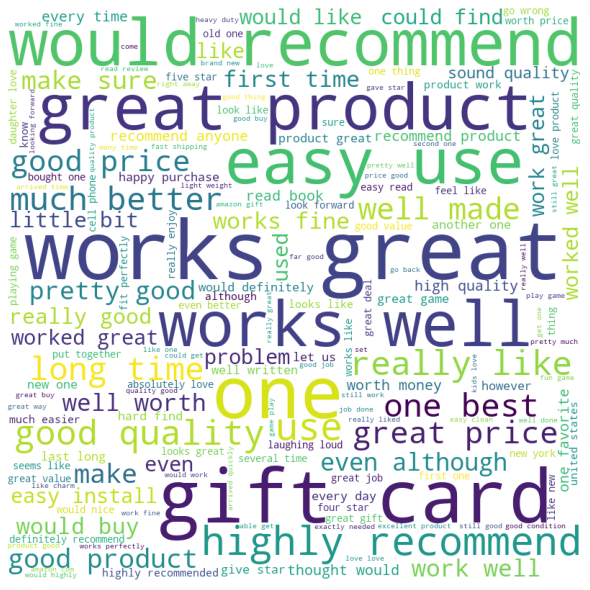

In [93]:
plot_wordcloud(positive_cloud)

#### Negative reviews

In [94]:
negative_corpus = " ".join(processed_df.loc[processed_df["polarity"] == -1.0, "review"].values.tolist())
negative_cloud = build_wordcloud(negative_corpus)

In [95]:
negative_freq = negative_cloud.words_

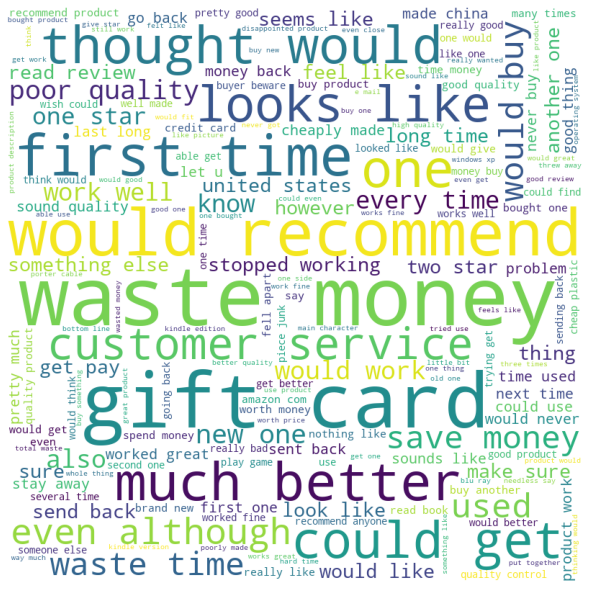

In [96]:
plot_wordcloud(negative_cloud)

#### Neutral reviews

In [97]:
neutral_corpus = " ".join(processed_df.loc[processed_df["polarity"] == 0.0, "review"].values.tolist())
neutral_cloud = build_wordcloud(neutral_corpus)

In [98]:
neutral_freq = neutral_cloud.words_

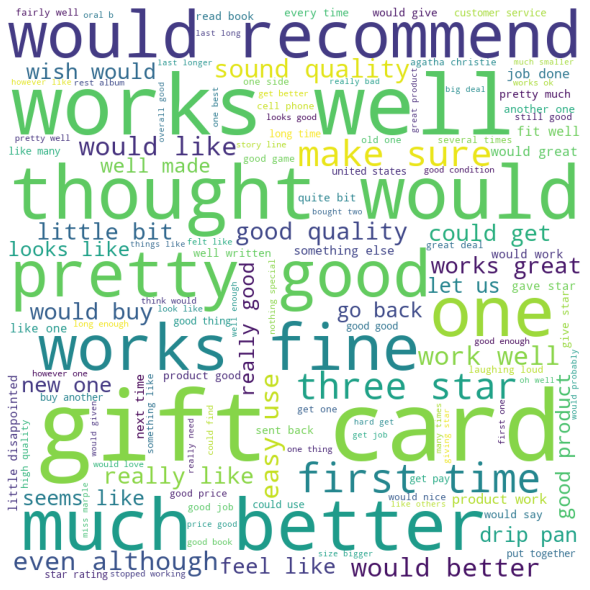

In [99]:
plot_wordcloud(neutral_cloud)

#### Common words in all reviews

The intersection of words in reviews of different sentiment could be viewed as not too oriented toward a specific sentiment and more neutral.

In [100]:
def extract_common_words(pos_freq, neg_freq, neu_freq):
    obj_freq = dict()
    for i,k in enumerate(neu_freq.keys()):
        if k not in neg_freq or k not in pos_freq:
            continue
        #freq = pos_freq[k] + neg_freq[k] + pos_freq[k]
        #obj_freq[k] = (freq - 0.0)/(3.0 - 0.0)
        obj_freq[k] = min(pos_freq[k], neg_freq[k], pos_freq[k])
    
    return obj_freq

In [101]:
obj_freqs = extract_common_words(positive_freq, negative_freq, neutral_freq)

In [102]:
objective_cloud = WordCloud(
    width=800, 
    height=800, 
    background_color='white',
    min_font_size = 10
).generate_from_frequencies(obj_freqs)

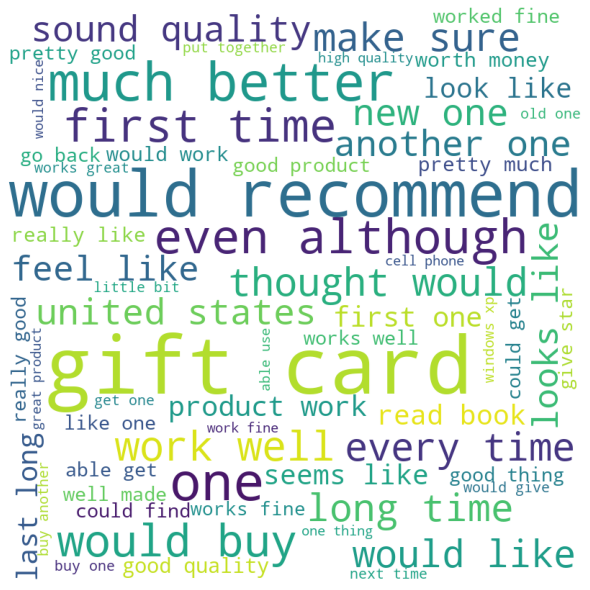

In [103]:
plot_wordcloud(objective_cloud)